In [1]:
%pip install pymongo

Note: you may need to restart the kernel to use updated packages.


# Crate Directory and Output File

In [2]:
#Use '/resource' to syncronize folder with host

!mkdir -p ~/output/sklearn-model/decission-tree

In [3]:
input_path  = "/home/jovyan/output/renamed-data/binary/TrainDataUnderSampling.csv"
output_path = "/home/jovyan/output/sklearn-model/decission-tree"

# Import Package

In [4]:
import time
import pickle
import numpy as np
import pandas as pd
from gridfs import GridFS
from statistics import mean
from datetime import datetime
from bson.binary import Binary
import matplotlib.pyplot as plt
from pymongo import MongoClient

from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# DB Connections

In [5]:
client = MongoClient("mongodb://mongodb:27017")
db = client['mataelanglab']

result_col = db['sklearn_result']
cv_col = db['sklearn_cv']
model_col = GridFS(db, 'sklearn_model')

# Read Data

In [6]:
df = pd.read_csv(input_path)

# Normalisasi

In [7]:
xNorm = df.drop(['Unnamed: 0','flow_id','src_ip','src_port','dst_ip','dst_port','protocol','timestamp','label'],axis=1)
yNorm = df[['label']]

In [8]:
stdScaler = StandardScaler()
normData = pd.DataFrame(stdScaler.fit_transform(xNorm), columns=xNorm.columns)
normData.head(5)

,flow_duration,total_fwd_packet,total_bwd_packets,total_length_of_fwd_packet,total_length_of_bwd_packet,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.377311,-0.044437,-0.053995,-0.003726,-0.046560,3.075022,-0.474292,1.190075,3.450602,-0.380966,...,-0.036528,0.237673,-0.314924,-0.057004,-0.293148,-0.313532,0.632930,-0.659378,-0.463769,0.650771
1,1.621775,-0.062786,-0.065338,-0.018863,-0.046926,-0.103881,-0.474292,-0.154518,0.089382,-0.522705,...,-0.036528,0.237673,-0.314924,-0.057004,-0.293148,-0.313532,-1.465506,1.506739,-0.463530,-1.509516
2,-0.290783,0.295013,0.059432,1.548795,-0.046611,8.110218,-0.474292,17.184021,5.072583,-0.400652,...,1.264708,0.237673,-0.314924,-0.057004,-0.293148,-0.313532,0.633043,-0.659378,-0.462282,0.650830
3,-0.410054,0.038132,0.082118,-0.010714,-0.028506,0.638636,-0.474292,-0.030761,0.348651,0.394661,...,0.305903,0.237673,-0.314924,-0.057004,-0.293148,-0.313532,0.632809,-0.659378,-0.465364,0.650709
4,1.405972,0.010609,-0.008624,-0.013477,-0.045711,-0.115483,-0.474292,-0.062998,0.010400,-0.440024,...,0.168931,0.237673,0.448076,-0.057004,0.370849,0.484196,-1.604441,1.363325,-4.123980,-1.509516


# All Data without Feature Selection

## Processing

In [9]:
start_time = time.time()
# Split dataset into training set and test set
xtrain, xtest, ytrain, ytest = train_test_split(normData, yNorm, test_size=0.3, random_state=42)

# Create Decision Tree classifer object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtModel = dt.fit(xtrain,ytrain)

#Predict the response for test dataset
ypred = dtModel.predict(xtest)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

--- 6.998743295669556 seconds ---


In [10]:
# Calculate Confusion matrix
print("confusion matrix :",confusion_matrix(ytest, ypred).ravel())
tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / ( tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
      "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [32149   520   542 32230]
accuracy :  0.9838
recall : 0.9835
precision :  0.9841
f1-measure : 0.9838


In [11]:
# Save Pickle
path = output_path+"/all-feature.pkl"
with open(path, "wb") as f:
    pickle_model = pickle.dump(dtModel, f)

In [12]:
# Store to MongoDB

with open(path, "rb") as f:
    model_col.put(f, filename="DecissionTree-AllFeature.pkl")
    
result_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "All Feature",
    'label': "Binary-Label",
    'duration': duration,
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1_score': f1_score,
    'created_at': datetime.fromtimestamp(time.time())
})

## Calculate Feature Weight to Get Importance Feature

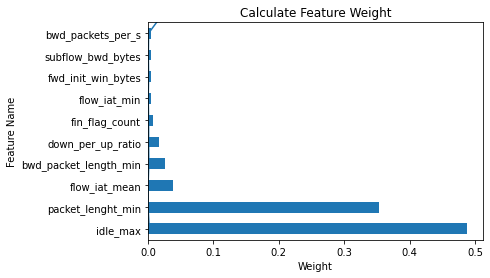

In [13]:
featureImportances = pd.Series(dt.feature_importances_, index= normData.columns)
featureImportances.nlargest(10).plot(kind='barh')

plt.title('Calculate Feature Weight') 
plt.xlabel('Weight') 
plt.ylabel('Feature Name')
p = plt.plot(featureImportances.values, featureImportances.index)

In [14]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

featureImp = pd.DataFrame({'Feature_names':normData.columns,'Importances':dt.feature_importances_})
featureImp.sort_values(by='Importances',ascending=False).head(15)

,Feature_names,Importances
74,idle_max,0.487686
37,packet_lenght_min,0.353579
15,flow_iat_mean,0.038862
10,bwd_packet_length_min,0.025351
50,down_per_up_ratio,0.017372
42,fin_flag_count,0.006897
18,flow_iat_min,0.005084
64,fwd_init_win_bytes,0.005058
63,subflow_bwd_bytes,0.004075
36,bwd_packets_per_s,0.003767


## Cross Validation Process

In [15]:
X=np.array(normData)
y=np.array(yNorm)

accList = []
recList = []
precList=[]
f1List=[]

kf= KFold(n_splits=10,shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X) :
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    dt = DecisionTreeClassifier()
    dtModel = dt.fit(X_train,y_train)
    
    y_pred = dtModel.predict(X_test)
    print("confusion matrix :", confusion_matrix(y_test,y_pred).ravel())
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    accList.append(accuracy)
    recList.append(recall)
    precList.append(precision)
    f1List.append(f1_score)
    
    print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
          "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [10681   167   175 10791]
accuracy :  0.9843
recall : 0.9840
precision :  0.9848
f1-measure : 0.9844
confusion matrix : [10647   184   177 10806]
accuracy :  0.9835
recall : 0.9839
precision :  0.9833
f1-measure : 0.9836
confusion matrix : [10801   185   156 10672]
accuracy :  0.9844
recall : 0.9856
precision :  0.9830
f1-measure : 0.9843
confusion matrix : [10768   169   168 10709]
accuracy :  0.9846
recall : 0.9846
precision :  0.9845
f1-measure : 0.9845
confusion matrix : [10670   185   173 10785]
accuracy :  0.9836
recall : 0.9842
precision :  0.9831
f1-measure : 0.9837
confusion matrix : [10698   178   178 10759]
accuracy :  0.9837
recall : 0.9837
precision :  0.9837
f1-measure : 0.9837
confusion matrix : [10683   173   177 10780]
accuracy :  0.9840
recall : 0.9838
precision :  0.9842
f1-measure : 0.9840
confusion matrix : [10647   154   193 10819]
accuracy :  0.9841
recall : 0.9825
precision :  0.9860
f1-measure : 0.9842
confusion matrix : [10799   179   175 10

In [16]:
print('accuracy : ',(mean(accList)))
print('recall : ',(mean(recList)))
print('precision : ',(mean(precList)))
print('f1_score : ',(mean(f1List)))

cv_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "All Feature",
    'label': "Binary-Label",
    'accuracy': (mean(accList)),
    'recall': (mean(recList)),
    'precision': (mean(precList)),
    'f1_score': (mean(f1List)),
    'created_at': datetime.fromtimestamp(time.time())
})

accuracy :  0.9839135529636793
recall :  0.9839938471408449
precision :  0.9838343198944017
f1_score :  0.9839134902731397


# Using Feature Importance

## Processing

In [17]:
importance = normData[[
    'idle_max',
    'fwd_init_win_bytes',
    'fwd_header_length',
    'bwd_packets_per_s',
    'flow_bytes_per_s',
    'bwd_init_win_bytes',
    'flow_iat_max'
]]

In [18]:
start_time = time.time()
# Split dataset into training set and test set
xftrain, xftest, yftrain, yftest = train_test_split(importance, yNorm, test_size=0.3, random_state=42)

# Create Decision Tree classifer object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtModel = dt.fit(xftrain,yftrain)

#Predict the response for test dataset
yfpred = dtModel.predict(xftest)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

--- 1.1013574600219727 seconds ---


In [19]:
print("confusion matrix :",confusion_matrix(yftest, yfpred).ravel())
tn, fp, fn, tp = confusion_matrix(yftest, yfpred).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / ( tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
      "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [32027   642   655 32117]
accuracy :  0.9802
recall : 0.9800
precision :  0.9804
f1-measure : 0.9802


In [20]:
# Save Pickle
path = output_path+"/feature-importance.pkl"
with open(path, "wb") as f:
    pickle_model = pickle.dump(dtModel, f)

In [21]:
# Store to MongoDB

with open(path, "rb") as f:
    model_col.put(f, filename="DecissionTree-FeatureImportance.pkl")
    
result_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "Feature Importance",
    'label': "Binary-Label",
    'duration': duration,
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1_score': f1_score,
    'created_at': datetime.fromtimestamp(time.time())
})

## Cross Validation Process

In [22]:
X=np.array(importance)
y=np.array(yNorm)

accList = []
recList = []
precList=[]
f1List=[]

kf= KFold(n_splits=10,shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X) :
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    dt = DecisionTreeClassifier()
    dtModel = dt.fit(X_train,y_train)
    
    y_pred = dtModel.predict(X_test)
    print("confusion matrix :", confusion_matrix(y_test,y_pred).ravel())
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    accList.append(accuracy)
    recList.append(recall)
    precList.append(precision)
    f1List.append(f1_score)
    
    print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
          "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [10670   220   238 10686]
accuracy :  0.9790
recall : 0.9782
precision :  0.9798
f1-measure : 0.9790
confusion matrix : [10658   216   196 10744]
accuracy :  0.9811
recall : 0.9821
precision :  0.9803
f1-measure : 0.9812
confusion matrix : [10782   209   190 10633]
accuracy :  0.9817
recall : 0.9824
precision :  0.9807
f1-measure : 0.9816
confusion matrix : [10717   230   193 10674]
accuracy :  0.9806
recall : 0.9822
precision :  0.9789
f1-measure : 0.9806
confusion matrix : [10631   224   222 10736]
accuracy :  0.9796
recall : 0.9797
precision :  0.9796
f1-measure : 0.9797
confusion matrix : [10644   233   225 10711]
accuracy :  0.9790
recall : 0.9794
precision :  0.9787
f1-measure : 0.9791
confusion matrix : [10667   214   194 10738]
accuracy :  0.9813
recall : 0.9823
precision :  0.9805
f1-measure : 0.9814
confusion matrix : [10602   181   216 10814]
accuracy :  0.9818
recall : 0.9804
precision :  0.9835
f1-measure : 0.9820
confusion matrix : [10707   206   204 10

In [23]:
print('accuracy : ',(mean(accList)))
print('recall : ',(mean(recList)))
print('precision : ',(mean(precList)))
print('f1_score : ',(mean(f1List)))

cv_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "Feature Importance",
    'label': "Binary-Label",
    'accuracy': (mean(accList)),
    'recall': (mean(recList)),
    'precision': (mean(precList)),
    'f1_score': (mean(f1List)),
    'created_at': datetime.fromtimestamp(time.time())
})

accuracy :  0.9806999384076771
recall :  0.9810719736837166
precision :  0.9803461510690846
f1_score :  0.9807080783715794


# Using PCA

## Processing

In [24]:
start_time = time.time()
pca = PCA(n_components=7)
pca_dataset = pd.DataFrame(pca.fit_transform(normData), columns=[
    "Feature 1",
    "Feature 2",
    "Feature 3",
    "Feature 4",
    "Feature 5",
    "Feature 6",
    "Feature 7"
])
#pca_dataset["Label"] = pca_label["Label"]
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

--- 3.3312323093414307 seconds ---


In [25]:
print(pca.explained_variance_)

[10.88449402  9.09396116  6.65470816  5.49491754  4.40487123  3.77902177
  3.05000117]


In [26]:
a = 0
for i in pca.explained_variance_:
  a = a+i
print(a)

43.3619750520958


In [27]:
start_time = time.time()
# Split dataset into training set and test set
xptrain, xptest, yptrain, yptest = train_test_split(pca_dataset, yNorm, test_size=0.3, random_state=42)

# Create Decision Tree classifer object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtModel = dt.fit(xptrain,yptrain)

#Predict the response for test dataset
yppred = dtModel.predict(xptest)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

--- 2.697516679763794 seconds ---


In [28]:
print("confusion matrix :",confusion_matrix(yptest, yppred).ravel())
tn, fp, fn, tp = confusion_matrix(yptest, yppred).ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / ( tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
      "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))

confusion matrix : [31858   811   782 31990]
accuracy :  0.9757
recall : 0.9761
precision :  0.9753
f1-measure : 0.9757


In [29]:
# Save Pickle
path = output_path+"/pca.pkl"
with open(path, "wb") as f:
    pickle_model = pickle.dump(dtModel, f)

In [30]:
# Store to MongoDB

with open(path, "rb") as f:
    model_col.put(f, filename="DecissionTree-PCA.pkl")
    
result_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "PCA",
    'label': "Binary-Label",
    'duration': duration,
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'f1_score': f1_score,
    'created_at': datetime.fromtimestamp(time.time())
})

## Cross Validation Process

In [31]:
X=np.array(pca_dataset)
y=np.array(yNorm)

accList = []
recList = []
precList=[]
f1List=[]

kf= KFold(n_splits=10,shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X) :
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    
    dt = DecisionTreeClassifier()
    dtModel = dt.fit(X_train,y_train)
    
    y_pred = dt.predict(X_test)
    print("confusion matrix :", confusion_matrix(y_test,y_pred).ravel())
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    accList.append(accuracy)
    recList.append(recall)
    precList.append(precision)
    f1List.append(f1_score)
    
    print(str('accuracy :  %0.4f' % accuracy) +"\n" + str('recall : %0.4f' % recall) +
          "\n" + str('precision :  %0.4f' %precision) + "\n" + str('f1-measure : %0.4f' %f1_score))
          

confusion matrix : [10596   270   278 10670]
accuracy :  0.9749
recall : 0.9746
precision :  0.9753
f1-measure : 0.9750
confusion matrix : [10648   282   263 10621]
accuracy :  0.9750
recall : 0.9758
precision :  0.9741
f1-measure : 0.9750
confusion matrix : [10653   258   261 10642]
accuracy :  0.9762
recall : 0.9761
precision :  0.9763
f1-measure : 0.9762
confusion matrix : [10665   294   231 10624]
accuracy :  0.9759
recall : 0.9787
precision :  0.9731
f1-measure : 0.9759
confusion matrix : [10605   286   276 10646]
accuracy :  0.9742
recall : 0.9747
precision :  0.9738
f1-measure : 0.9743
confusion matrix : [10650   281   286 10596]
accuracy :  0.9740
recall : 0.9737
precision :  0.9742
f1-measure : 0.9739
confusion matrix : [10615   284   271 10643]
accuracy :  0.9746
recall : 0.9752
precision :  0.9740
f1-measure : 0.9746
confusion matrix : [10653   249   268 10643]
accuracy :  0.9763
recall : 0.9754
precision :  0.9771
f1-measure : 0.9763
confusion matrix : [10597   249   294 10

In [32]:
print('accuracy : ',(mean(accList)))
print('recall : ',(mean(recList)))
print('precision : ',(mean(precList)))
print('f1_score : ',(mean(f1List)))

cv_col.insert_one({
    'machine_learning': "Decission Tree",
    'feature': "PCA",
    'label': "Binary-Label",
    'accuracy': (mean(accList)),
    'recall': (mean(recList)),
    'precision': (mean(precList)),
    'f1_score': (mean(f1List)),
    'created_at': datetime.fromtimestamp(time.time())
})

accuracy :  0.9751666344134685
recall :  0.9752657959078841
precision :  0.975075692043675
f1_score :  0.9751692882384699
